# Check spinup day

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

# Man class

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.qv = self.getVar("grid_tracers_c_xyz1t")
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyz1t")
        # self.grid_t_eq_ref_xyzt = self.getVar("grid_t_eq_ref_xyzt")
        self.omega   = self.getVar("grid_w_full_xyzt")
        
        
        self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        self.Uzm   = np.nanmean(self.u, axis=3)
        self.Vzm   = np.nanmean(self.v, axis=3)
        self.THzm  = np.nanmean(self.theta, axis=3)
        self.Pzm   = np.nanmean(self.p, axis=3)
        self.Tzm   = np.nanmean(self.t, axis=3)
        
        ### anamoly
        self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        self.THzmtm = np.nanmean(self.THzm, axis=0)
        self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        self.Vza     = np.zeros(self.u.shape)
        self.Uza     = np.zeros(self.u.shape)
        self.THETAza = np.zeros(self.u.shape)
        self.Pza     = np.zeros(self.u.shape)
        self.Tza     = np.zeros(self.t.shape)

        for i in range(0,128):
            self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
            self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
            self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
            self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
            self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.Prec[:,i,:,:] = 1/self.g * self.qv_diff[:,i,:,:] * (self.p[:,i+1,:,:] - self.p[:,i-1,:,:])/2
        self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p[:, 1,:,:] - self.p[:, 0,:,:])/2
        self.Prec[:,-1,:,:] = 1/self.g * self.qv_diff[:,-1,:,:] * (self.p[:,-1,:,:] - self.p[:,-2,:,:])/2
        
        self.Prec_mean  = np.nanmean(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean

In [3]:
time = np.linspace(0,1600,1600)
y    = np.linspace(-90,90,64)

yy, tt = np.meshgrid(y,time)

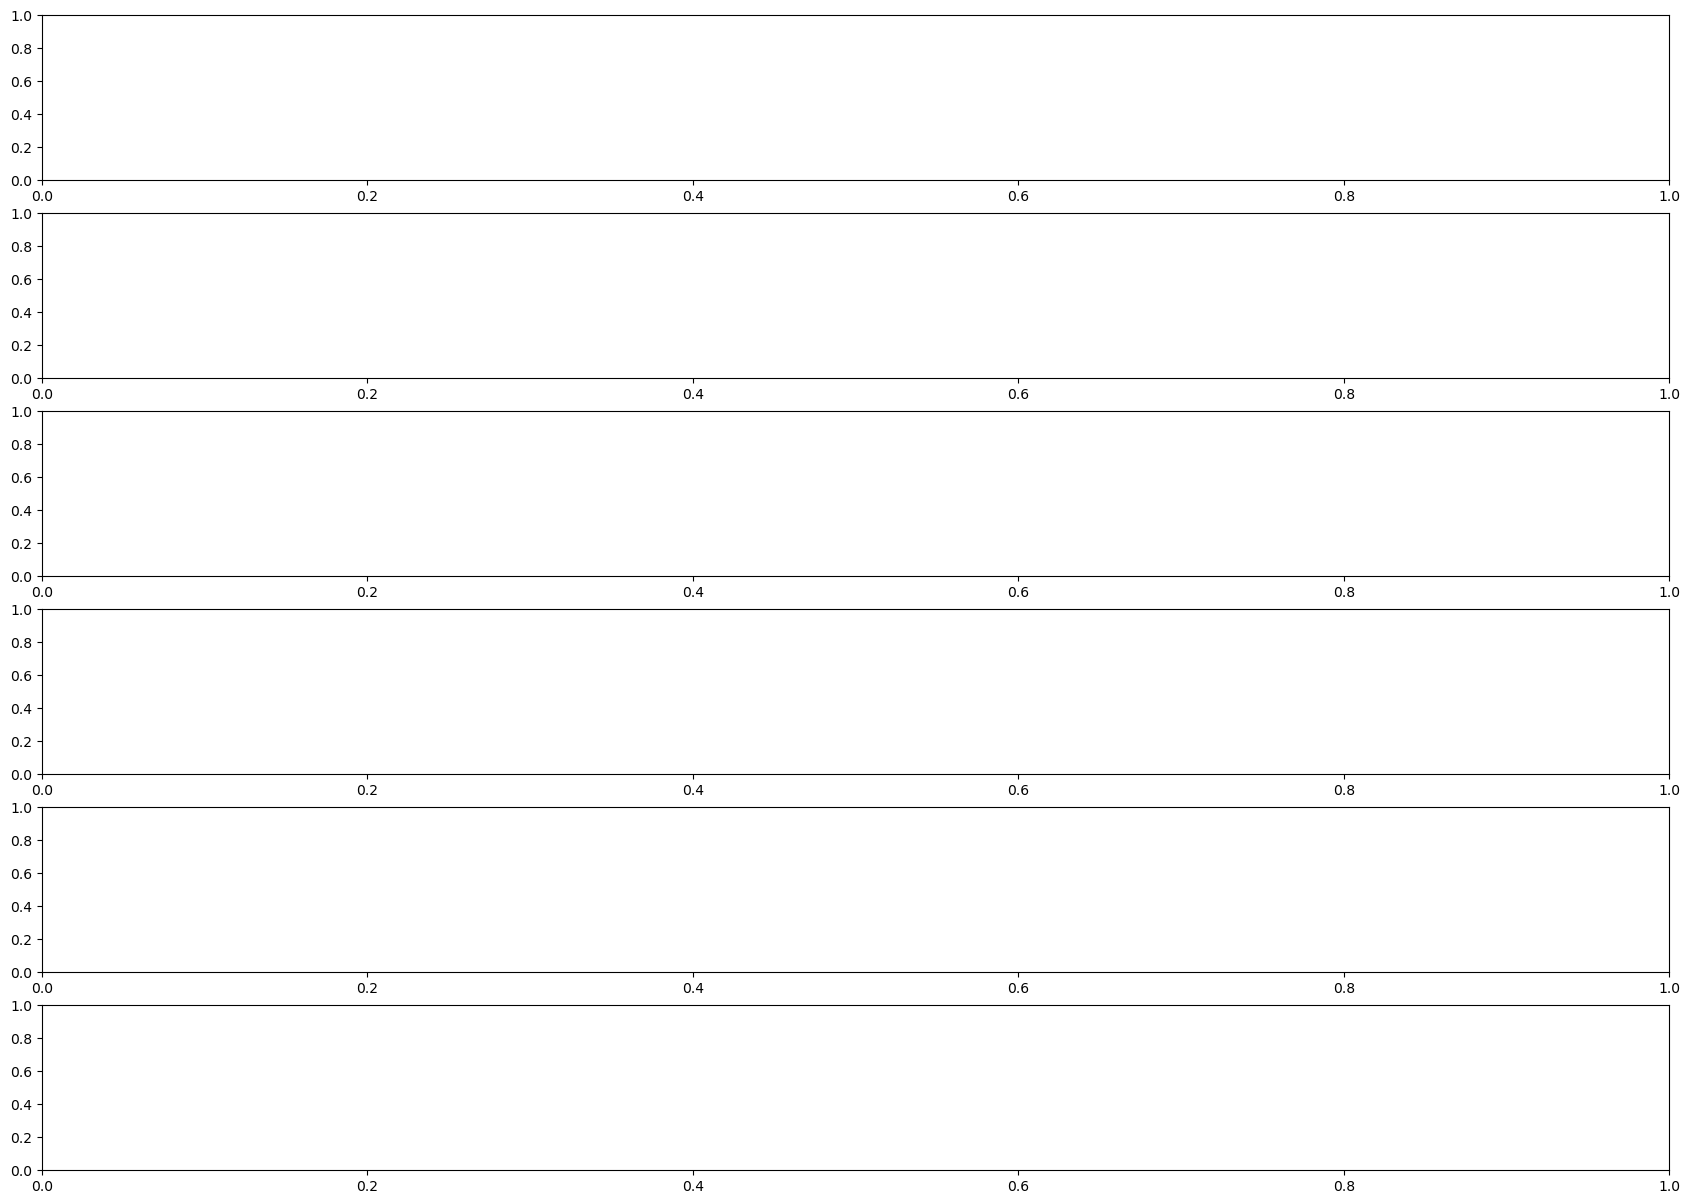

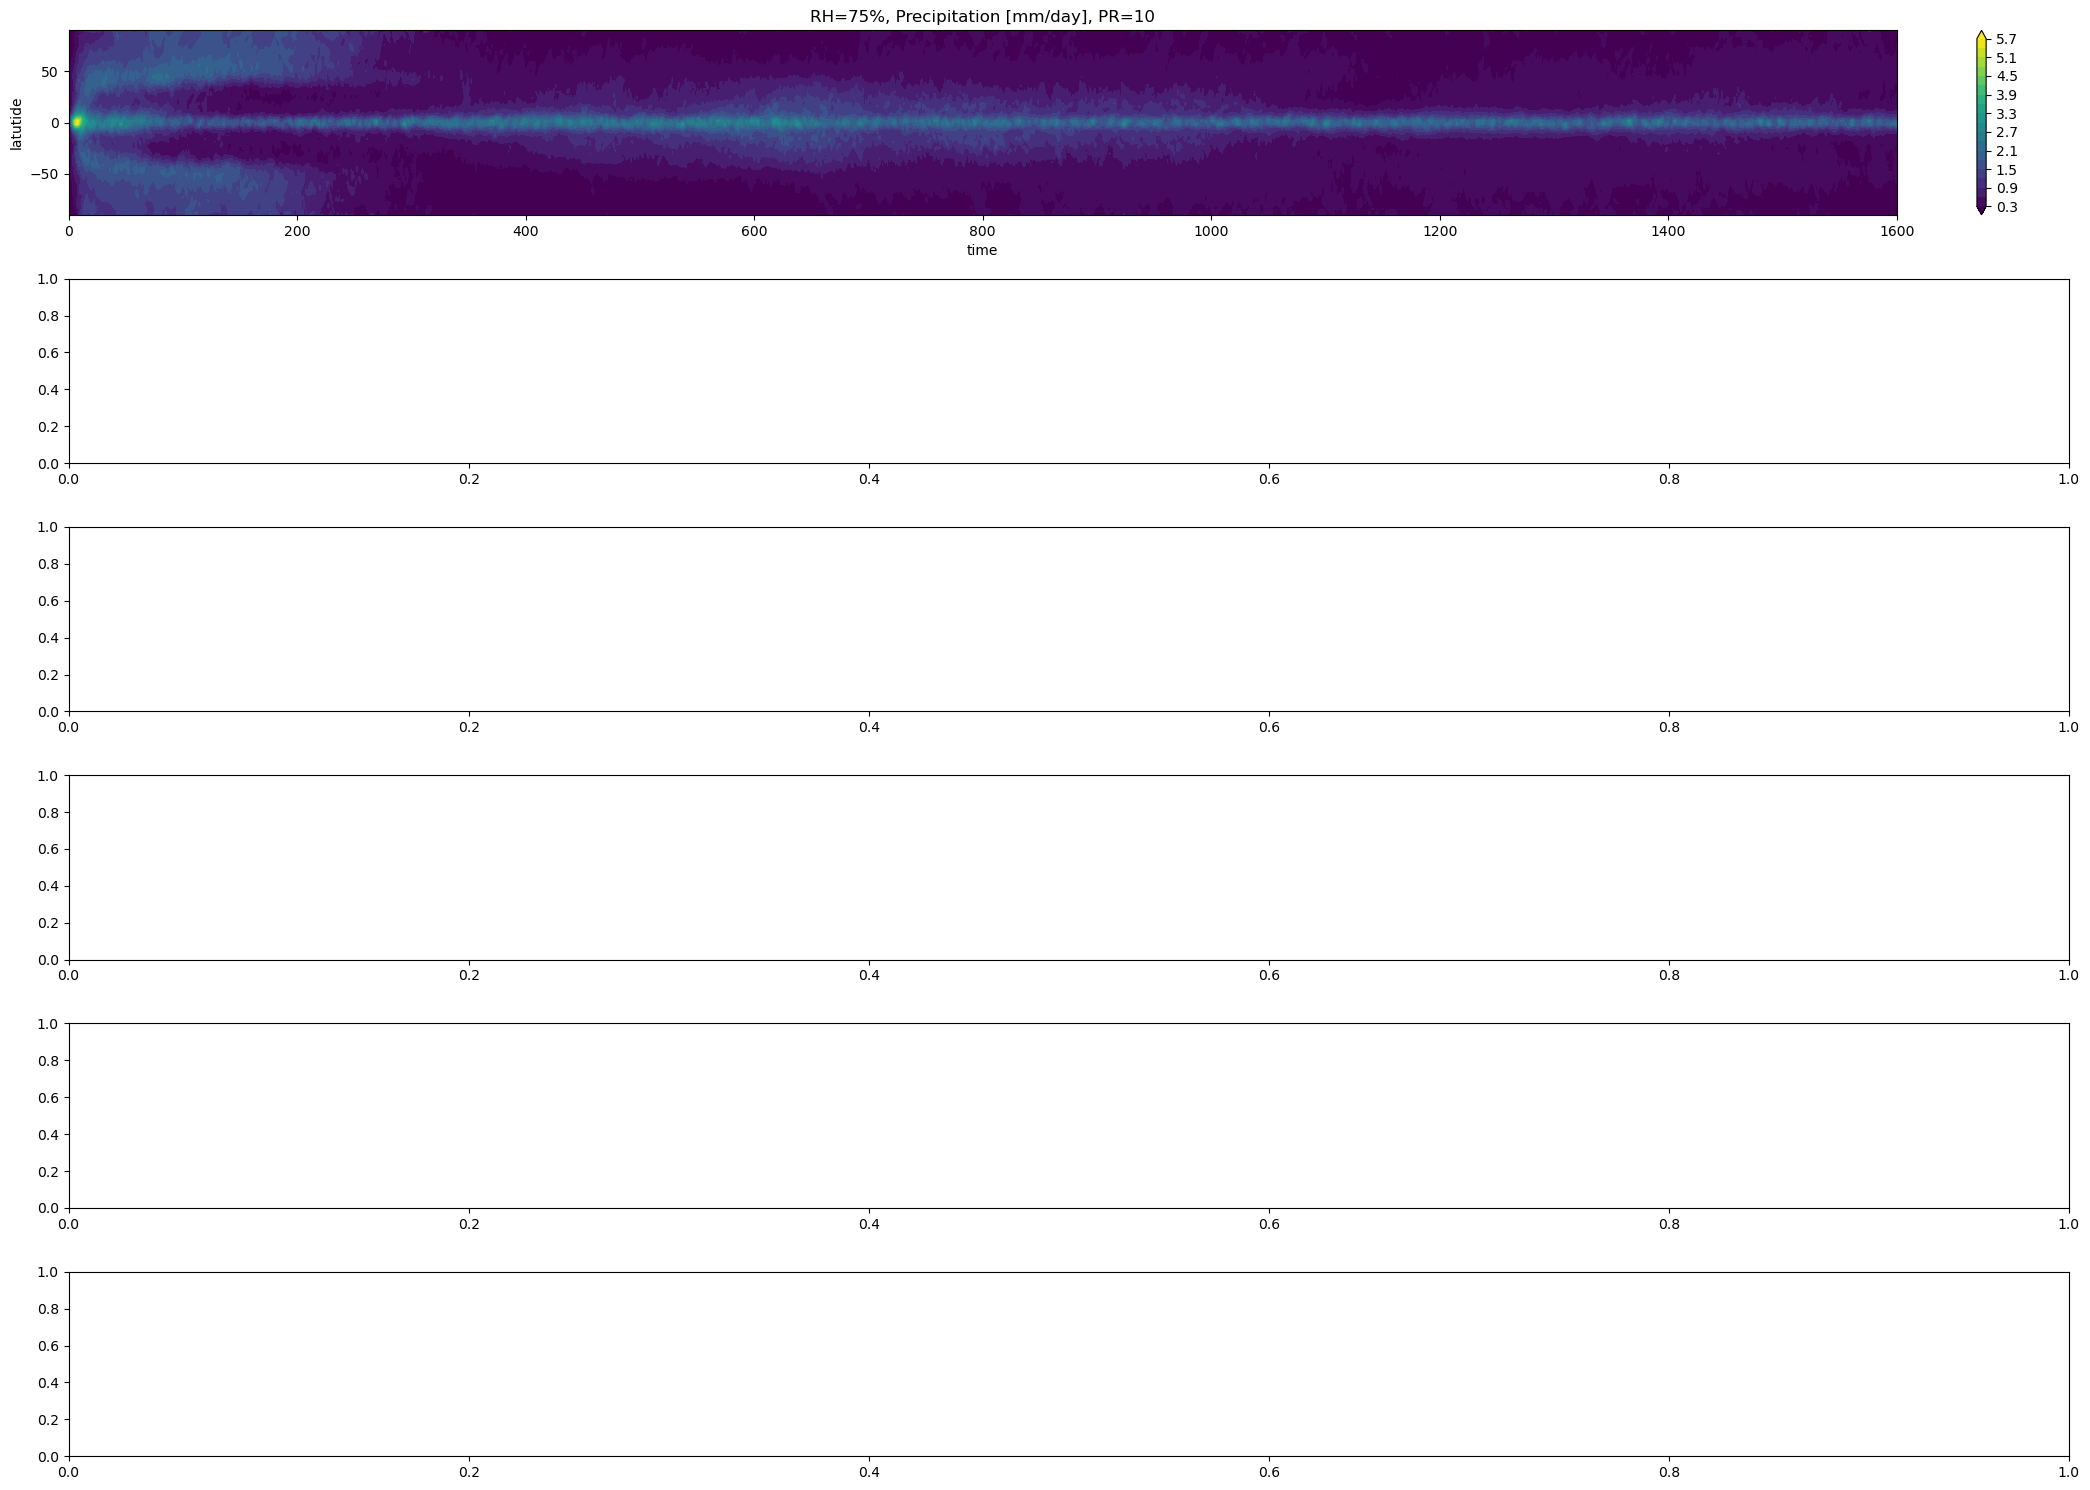

In [35]:
a = int(0)
fig, ax = plt.subplots(6, figsize=(21,15))
for pr in range(10,15,5):
    # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    file = "t_init_RH63_PR10_1600day_test_all.dat"
    dycore = Dycore(file)
    # get_KE = dycore.cal_KE()   
    Prec   = dycore.cal_pre()
    # t_mean = dycore.cal_t()
    # t_mean2 = dycore.cal_t_last()
    
    
    # CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(150,1050,7), extend="both")
    
    CS = ax[a].contourf(tt, yy, Prec * int(pr),levels=21, extend="both")
        
    # CS = ax[a].contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
    fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
    # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
    ax[a].set_title(f"RH=75%, Precipitation [mm/day], PR={pr}")
    # ax[a].set_title(f"T [K], PR={pr}")
    
    ax[a].set_xlabel("time")
    ax[a].set_ylabel("latutide")
    a += 1
    ### test
    
plt.tight_layout()
# plt.savefig("Check_Precipitation.png", dpi=300., bbox_inches='tight')
plt.show()



# Cal Muti PRs

In [5]:
# a = int(0)
# fig, ax = plt.subplots(6, figsize=(21,15))
# for pr in range(10,20,5):
#     # file   = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     file = f"for_Checking_800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"
#     dycore = Dycore(file)
#     get_KE = dycore.cal_KE()   
#     Prec   = dycore.cal_pre()
#     t_mean = dycore.cal_t()
    
#     # CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(150,1050,7), extend="both")
#     CS = ax[a].contourf(tt, yy, Prec * int(pr),levels=21, extend="both")
#     # CS = ax[a].contourf(tt, yy, t_mean, extend="both")
    
    
#     fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
#     # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
#     ax[a].set_title(f"Precipitation [mm/day], PR={pr}")
#     # ax[a].set_title(f"T [K], PR={pr}")
    
#     ax[a].set_xlabel("time")
#     ax[a].set_ylabel("latutide")
#     a += 1
#     ### test
    
# plt.tight_layout()
# # plt.savefig("Check_Precipitation.png", dpi=300., bbox_inches='tight')
# plt.show()



In [6]:
# a = int(0)
# fig, ax = plt.subplots(6, figsize=(21,15))
# for pr in range(0,30,5):
#     file   = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
#     dycore = Dycore(file)
#     get_KE = dycore.cal_KE()   
#     # Prec   = dycore.cal_pre()
#     # t_mean = dycore.cal_t()
    
#     # CS = ax[a].contourf(tt, yy, get_KE,levels=np.linspace(150,1050,7), extend="both")
#     # CS = ax[a].contourf(tt, yy, Prec,levels=np.linspace(0,0.35,7), extend="both")
#     get_KE2 = np.nanmean(get_KE, axis=1)
#     CS = ax[a].plot(get_KE2)
    
    
#     # fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
#     # ax[a].set_title(f"Precipitation [mm/day], PR={pr}")
#     ax[a].set_title(f"T [K], PR={pr}")
    
#     ax[a].set_xlabel("time")
#     ax[a].set_ylabel("latutide")
#     a += 1
#     ### test
    
# plt.tight_layout()
# # plt.savefig("Check_Precipitation.png", dpi=300., bbox_inches='tight')
# plt.show()



# Cal MSE

In [8]:
plt.figure(dpi=100.)
def cal_MSE():
    for pr in range(0,25,5):
        file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final = np.nanmean(MSE[:-200,:,:,:], axis=(0,1,3))
        
        plt.plot(final/1000, label=f"PR = {pr}")
    plt.title("MSE[kJ/kg], 1400-1600day mean")
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    plt.legend()
    # plt.ylabel("hPa")
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE()


In [ ]:
plt.figure(dpi=100.)
def cal_MSE_minus():
    for pr in [0]:
        file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final0 = np.nanmean(MSE[:-200,:,:,:], axis=(0,1,3))
        
        plt.plot(final0-final0, label=f"PR = {pr}")
        
    for pr in range(5,25,5):
        file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final = np.nanmean(MSE[:-200,:,:,:], axis=(0,1,3))
        
        plt.plot((final - final0)/1000, label=f"PR = {pr}")
    plt.title("MSE[kJ/kg] minus PR=0, 1400-1600day")
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    plt.legend()
    # plt.ylabel("hPa")
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE_minus()


KeyboardInterrupt: 

# Cal Prec

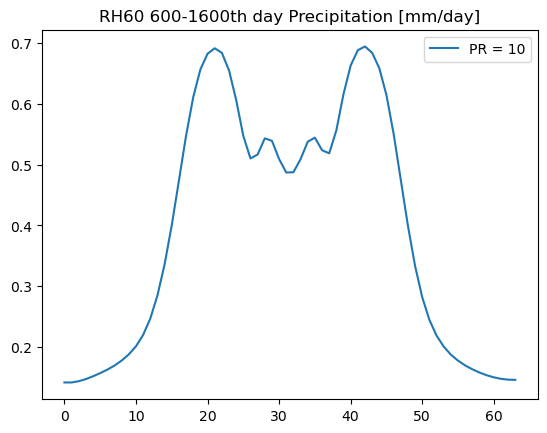

In [52]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
# plt.title("RH60 0-200th day Precipitation [mm/day]")
plt.title("RH60 600-1600th day Precipitation [mm/day]")


for pr in range(10,15,5):
    # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    file = "t_init_RH60_PR10_1600day_test_all.dat"
    dycore = Dycore(file)
    Prec   = dycore.cal_pre()
    Prec_mean  = np.nanmean(Prec[600:,:], axis=0)
    plt.plot(Prec_mean * int(pr), label=f"PR = {pr}")
plt.legend()
plt.show()

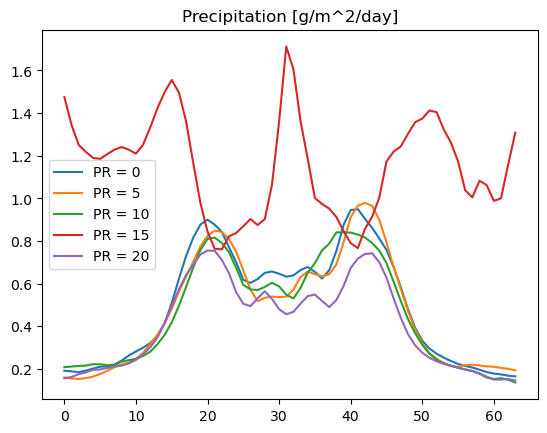

In [ ]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("Precipitation [g/m^2/day]")

for pr in range(0,25,5):
    file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    dycore = Dycore(file)
    Prec   = dycore.qv_diff
    Prec_mean  = np.nansum(Prec[-5:,:,:,:], axis=(0,1,3))
    plt.plot(Prec_mean , label=f"PR = {pr}")
plt.legend()
plt.show()

In [ ]:
# ### cooridate
# x  = np.linspace(-180,180,128)
# y  = np.linspace(-90,90,64)
# xd = np.deg2rad(x)
# yd = np.deg2rad(y)

# # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
# cy     = np.cos(yd)
# cy[0]  = np.nan
# cy[-1] = np.nan
# file  = "HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
# file2  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

# dycore = Dycore(file)

# def from_qv_to_p(file):
#     dycore = Dycore(file)
    
#     qv_diff = dycore.getVar("grid_tracers_diff_xyz1t")
#     t       = dycore.getVar("grid_t_c_xyzt")
    
#     qv_diff_sum = np.nansum(qv_diff[:,:,:,:], axis=(0,3))
#     qv_diff_sum_new = np.zeros(qv_diff_sum.shape)
#     pre = np.zeros((20,64))
#     rho             = np.zeros((20,64))
    
#     p_mean = np.nanmean(p, axis=(0,3))
#     t_mean = np.nanmean(t, axis=(0,3))
    
#     z_mean = np.nanmean(z, axis=(0,3))
    
#     for i in range(1,64-1):
#         qv_diff_sum_new[:,i] = qv_diff_sum[:,i] * cy[i]**0.5
#     for i in range(1,64-1):
#         rho[:,i] = p_mean[:,i] / 287 / t_mean[:,i] 

#     for i in range(64):
#         pre[:,i] = qv_diff_sum_new[:,i] * rho[:,i]
#     pre_final = np.nansum(pre,axis=0)
#     return pre_final

# pre = from_qv_to_p(file)
# pre2 = from_qv_to_p(file2)

# plt.figure()
# plt.plot(pre)
# plt.plot(pre2)
# plt.title("Precipitation [g/m^2/day]")
# plt.show()

# Cal qv

In [7]:
file = "t_init_RH75_PR10_1600day_test_all.dat"
dycore = Dycore(file)

In [8]:
v_o = dycore.v
w_o = -dycore.omega
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
u = dycore.u
p = dycore.p
ps = dycore.ps
qv = dycore.qv
qv_diff = dycore.qv_diff
t = dycore.t
Lv = 2.5 * 10**6
Rv = 461

w = np.nanmean(w_o[-200:], axis=(0,3))
v = np.nanmean(v_o[-200:], axis=(0,3))

In [40]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

rho_0     = np.zeros((20,64))
rho_0_all = np.zeros(u.shape)
for i in range(0,20):
    rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
    rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]  
# phi
a = 6.37122e6
lat   = np.linspace(-90, 90, 64)
phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
cphi  = np.cos(phi) 
acphi = a * cphi

psi_w1 = np.zeros((20,64))
psi_w2 = np.zeros((20,64))

psi_w1[:,0] = 0
for ilat in range(1,64-1):
    dlat = phi[:,ilat] - phi[:,ilat-1]       
    psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * (w)[:,ilat])
    # print(psi_w1[:,ilat])

psi_w2[:,64-1] = 0    
for jlat in range(1,64-1):
    ilat = 64 - 1 - jlat
    dlat = phi[:,ilat] - phi[:,ilat+1]           
    psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * (w)[:,ilat])

psi_w = 0.5*(psi_w1 + psi_w2)
###
qv_mean = np.nanmean(qv[-200:,:,:,:], axis=(0,3))
###



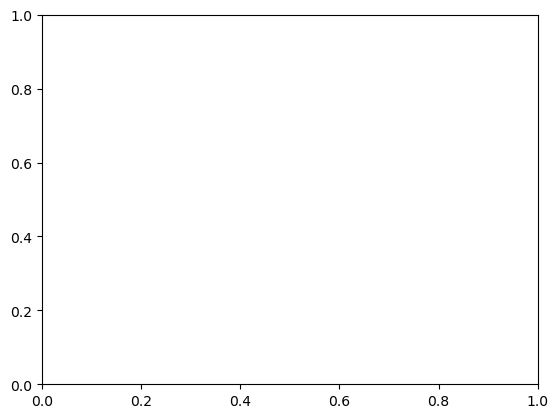

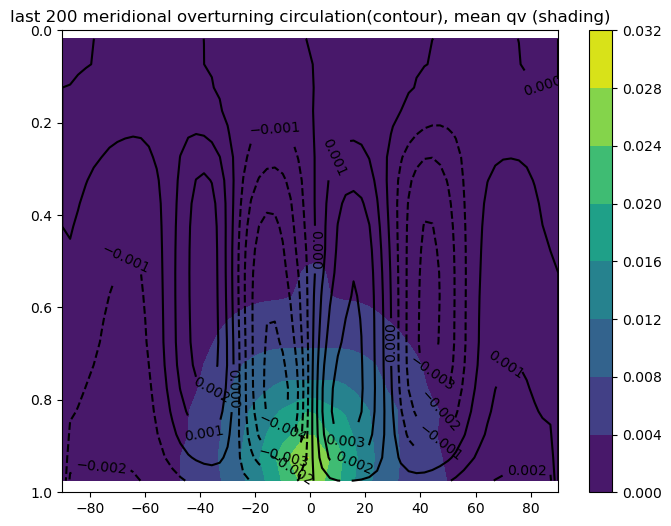

In [41]:
plt.figure(figsize=(8,6),dpi=100.)
CS = plt.contourf(yy, sigma_mean2, qv_mean)

CT = plt.contour(yy, sigma_mean2, psi_w, colors='k')

plt.colorbar(CS)

plt.clabel(CT)

plt.ylim([1,0])
plt.title("last 200 meridional overturning circulation(contour), mean qv (shading)")
plt.show()

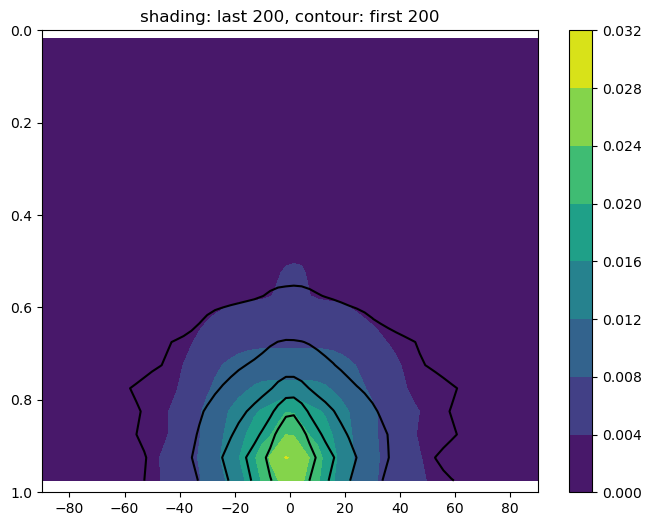

In [42]:
### first 200 day 
w_1 = np.nanmean(w_o[:200], axis=(0,3))
v_1 = np.nanmean(v_o[:200], axis=(0,3))

# rho_0     = np.zeros((20,64))
# rho_0_all = np.zeros(u.shape)
# for i in range(0,20):
#     rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
#     rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]  
# phi
a = 6.37122e6
lat   = np.linspace(-90, 90, 64)
phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
cphi  = np.cos(phi) 
acphi = a * cphi

psi_w1_1 = np.zeros((20,64))
psi_w2_1 = np.zeros((20,64))

psi_w1_1[:,0] = 0
for ilat in range(1,64-1):
    dlat = phi[:,ilat] - phi[:,ilat-1]       
    psi_w1_1[:,ilat] =  psi_w1_1[:,ilat-1] + (dlat * (w_1)[:,ilat])
    # print(psi_w1[:,ilat])

psi_w2_1[:,64-1] = 0    
for jlat in range(1,64-1):
    ilat = 64 - 1 - jlat
    dlat = phi[:,ilat] - phi[:,ilat+1]           
    psi_w2_1[:,ilat] =  psi_w2_1[:,ilat+1] + (dlat * (w_1)[:,ilat])

psi_w_1 = 0.5*(psi_w1_1 + psi_w2_1)
###
qv_mean_1 = np.nanmean(qv[:200,:,:,:], axis=(0,3))
###
plt.figure(figsize=(8,6),dpi=100.)
CS = plt.contour(yy, sigma_mean2, qv_mean_1, levels=np.linspace(0, 0.032, 9), colors='k')

# CT = plt.contour(yy, sigma_mean2, psi_w, colors='k')

# plt.colorbar(CS)

# plt.clabel(CT)

plt.ylim([1,0])
# plt.title("first 200 meridional overturning circulation(contour), mean qv (shading)")
plt.title("shading: last 200, contour: first 200")
#########################
CS = plt.contourf(yy, sigma_mean2, qv_mean)

# CT = plt.contour(yy, sigma_mean2, psi_w, colors='k')

plt.colorbar(CS)

plt.clabel(CT)

plt.ylim([1,0])
############################
plt.show()

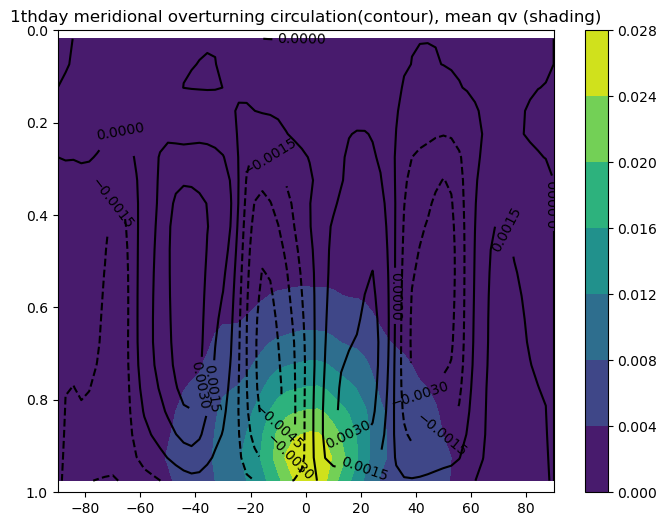

In [43]:
### first 200 day 
w = np.nanmean(w_o[:1], axis=(0,3))
v = np.nanmean(v_o[:1], axis=(0,3))

rho_0     = np.zeros((20,64))
rho_0_all = np.zeros(u.shape)
for i in range(0,20):
    rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
    rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]  
# phi
a = 6.37122e6
lat   = np.linspace(-90, 90, 64)
phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
cphi  = np.cos(phi) 
acphi = a * cphi

psi_w1 = np.zeros((20,64))
psi_w2 = np.zeros((20,64))

psi_w1[:,0] = 0
for ilat in range(1,64-1):
    dlat = phi[:,ilat] - phi[:,ilat-1]       
    psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * (w)[:,ilat])
    # print(psi_w1[:,ilat])

psi_w2[:,64-1] = 0    
for jlat in range(1,64-1):
    ilat = 64 - 1 - jlat
    dlat = phi[:,ilat] - phi[:,ilat+1]           
    psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * (w)[:,ilat])

psi_w = 0.5*(psi_w1 + psi_w2)
###
qv_mean = np.nanmean(qv[:1,:,:,:], axis=(0,3))
###
plt.figure(figsize=(8,6),dpi=100.)
CS = plt.contourf(yy, sigma_mean2, qv_mean, levels=np.linspace(0, 0.028, 8))

CT = plt.contour(yy, sigma_mean2, psi_w, colors='k')

plt.colorbar(CS)

plt.clabel(CT)

plt.ylim([1,0])
plt.title("1thday meridional overturning circulation(contour), mean qv (shading)")
plt.show()

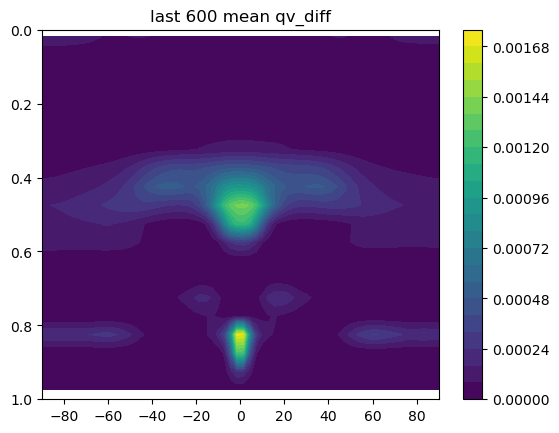

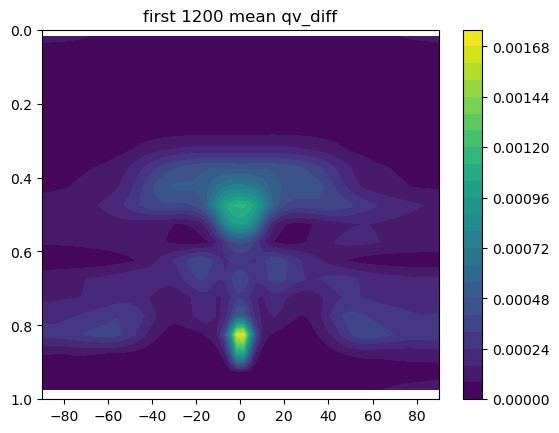

In [48]:
plt.figure(dpi=100.)
qv_diff_mean = np.nanmean(qv_diff[-600:,:,:,:], axis=(0,3))
# qv_diff_mean = np.nanmean(qv_diff[-100:,:,:,:], axis=(0,3))

CS = plt.contourf(yy, sigma_mean2, qv_diff_mean, levels=21)
plt.colorbar(CS)
plt.title("last 600 mean qv_diff")

plt.ylim([1,0])
plt.show()
#######################
plt.figure(dpi=100.)
qv_diff_mean = np.nanmean(qv_diff[:1200,:,:,:], axis=(0,3))

CS = plt.contourf(yy, sigma_mean2, qv_diff_mean, levels=21)
plt.colorbar(CS)
plt.title("first 1200 mean qv_diff")

plt.ylim([1,0])
plt.show()

In [ ]:
qv_mean = np.nanmean(qv[350:355,:,:,:], axis=(0,1,3))


cc = (0.622 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / t)) )) / (p - 0.378 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / t)) )) 
cc_mean = np.nanmean(cc[350:355,:,:,:], axis=(0,1,3))

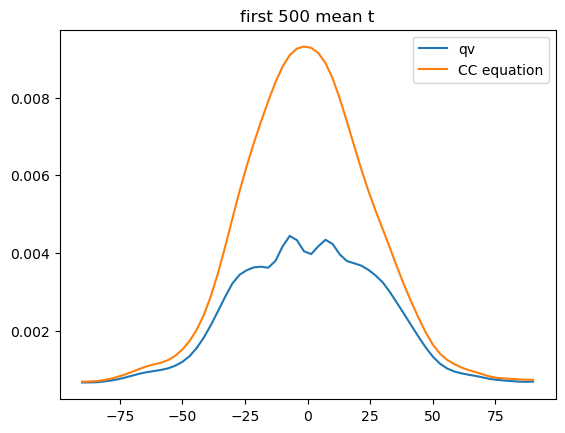

In [ ]:
plt.plot(y,qv_mean, label='qv')
plt.plot(y, cc_mean, label="CC equation")
plt.title("first 500 mean t")

plt.legend()
plt.show()

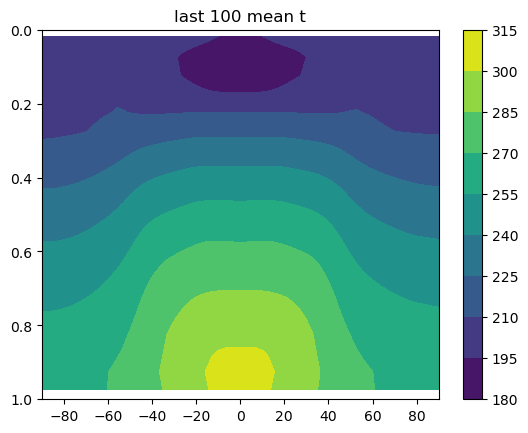

In [ ]:
plt.figure(dpi=100.)
t_mean = np.nanmean(t[-100:,:,:,:], axis=(0,3))
CS = plt.contourf(yy, sigma_mean2, t_mean)
plt.colorbar(CS)
# plt.title("first 500 mean t")
plt.title("last 100 mean t")


plt.ylim([1,0])
plt.show()

In [9]:
phi_hw = 2 * np.pi / 9 * np.deg2rad(40)
q0     = 18E-3
sigma = np.linspace(0,1,20)
phi   = np.linspace(-90,90,64)
p0    = 100000
p_hw  = 30000

q = np.zeros((20,64))

for i in range(20):
    q[i,:] = q0 * np.exp(-(np.deg2rad(phi) / phi_hw)**4) * np.exp(-((sigma[i] - 1) * (p0 / p_hw))**2)


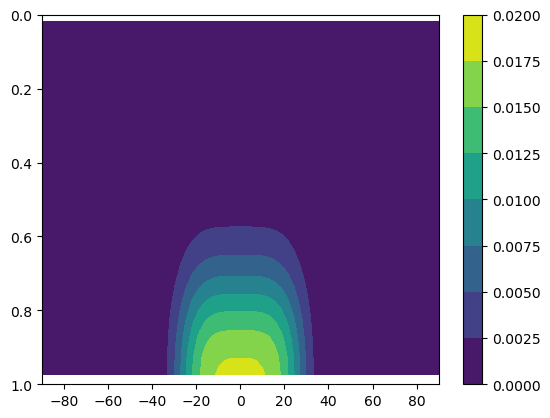

In [10]:
CS = plt.contourf(yy, sigma_mean2, q)
plt.ylim([1,0])
plt.colorbar(CS)
plt.show()